<a href="https://colab.research.google.com/github/CNyang5389/Financial_Engineering/blob/master/ST456_WT2024_Assignment1_27271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# importing necessary modules
import time
# deep learning modules
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Flatten, MaxPooling2D, Conv2D,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
# data preprocessing
from keras.utils import to_categorical

In [3]:
# Model fit. Remember to use the CPU runtime and set the seed before:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Helpful functions
Here are some functions which will be useful for the assignment.

In [4]:
# Plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes

def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [5]:
# Per class, extract the indexes of correctly and uncorrectly predicted data points

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

In [6]:
# Per class, plot a given number (i_max * j_max) of spectrograms

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that you want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

In [7]:
# Per class, print the predictions of those points that were wrongly classified

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

In [8]:
# Compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [9]:
# Per class, plot a given number (i_max * j_max) of Grad-CAM heatmaps

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

# Download data
After having loaded them to the Google Drive associated to your colab account (you can also load them manually, in that case modify the path accordingly).

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
npzfile = np.load('/content/drive/MyDrive/Colab_Notebooks/ST456_WT2024_data_assign1 (1).npz')

# features
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

In [12]:
print("Arrays in dataset:", npzfile.files)
x_train_shape = npzfile['x_train'].shape
print("Shape of 'x_train':", x_train_shape)
input_size = x_train_shape[1:]  # This excludes the number of samples
print("Input size for the model:", input_size)
y_train_num = npzfile['y_train_num']
num_classes = np.max(y_train_num) + 1
print(num_classes)

Arrays in dataset: ['x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test', 'y_train_num', 'y_val_num', 'y_test_num']
Shape of 'x_train': (3959, 80, 80, 1)
Input size for the model: (80, 80, 1)
4


In [13]:
# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

# P1

In [14]:
# Model definition and compilation.

**Q1. How many parameters does the model train? Before performing the training, do you expect this model to overfit? Which aspects would influence the overfitting (or not) of this model?**

Ans:
It is a convolutional neural network with 84382 trainable parameters.
There might be a risk of overfitting because the number of parameters is relatively large compared to the sample size, while the model has 84382 parameters and the samples size is 3959. Overfitting often occurs when the number of parameters is high relatively to the number of training samples. Fortunately, the regularization methods (L2 regularization) can help to avoid overfitting by constraining the weights anf adding a penalty. Thus, in my opinion, the chance of overfitting may be about half and half.




In [15]:
# rest of P1...
input_shape=(80, 80, 1)
model1 = Sequential()
model1.add(Conv2D(4,(5,5),input_shape=input_shape,padding='same',activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(8,(5,5),padding='same',activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(16,(5,5),padding='same',activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Flatten())
model1.add(Dense(50, activation='relu', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=keras.regularizers.l2(0.01)))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

In [16]:
model1.compile(optimizer=SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history2 = model1.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/20
124/124 [==============================] - 20s 158ms/step - loss: 1.9997 - accuracy: 0.5335 - val_loss: 1.7936 - val_accuracy: 0.6479
Epoch 2/20
124/124 [==============================] - 18s 145ms/step - loss: 1.6511 - accuracy: 0.6893 - val_loss: 1.6463 - val_accuracy: 0.6697
Epoch 3/20
124/124 [==============================] - 18s 145ms/step - loss: 1.5310 - accuracy: 0.7176 - val_loss: 1.4830 - val_accuracy: 0.7261
Epoch 4/20
124/124 [==============================] - 19s 153ms/step - loss: 1.4434 - accuracy: 0.7512 - val_loss: 1.4240 - val_accuracy: 0.7307
Epoch 5/20
124/124 [==============================] - 19s 152ms/step - loss: 1.3564 - accuracy: 0.7714 - val_loss: 1.3807 - val_accuracy: 0.7353
Epoch 6/20
124/124 [==============================] - 17s 141ms/step - loss: 1.2736 - accuracy: 0.7853 - val_loss: 1.3056 - val_accuracy: 0.7791
Epoch 7/20
124/124 [==============================] - 19s 155ms/step - loss: 1.2214 - accuracy: 0.7944 - val_loss: 1.2497 - val_ac

Text(0.5, 0.98, 'Loss and accuracy')

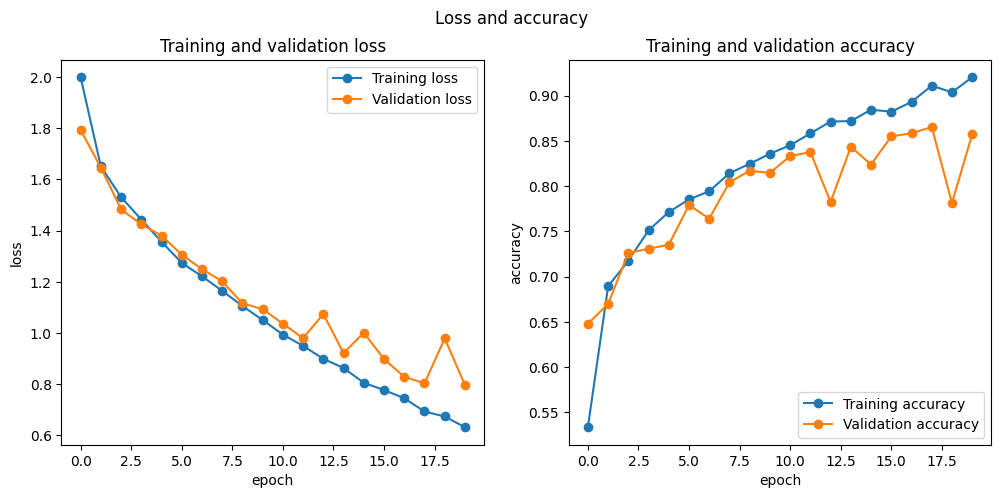

In [17]:
# training and validation loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history2.history['loss'],'-o', label='Training loss')
ax1.plot(history2.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history2.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history2.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('Loss and accuracy')

**Q2. Plot the loss function and the accuracy per epoch for the train and validation sets.**

Ans: Shown as above.

In [17]:
score = model1.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 85.49%


**Q3. Which accuracy do you obtain on the test set?**

Ans: The test accuracy is 85.49%

37/37 [==============================] - 0s 3ms/step


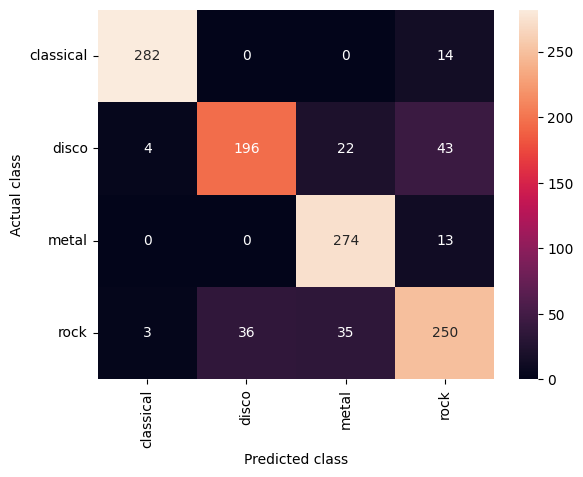

In [18]:
predictions = model1.predict(x_test)
# Convert predictions from one-hot encoded to numerical labels if necessary
y_pred_num = np.argmax(predictions, axis=1)
plot_confusion_matrix(y_test_num, y_pred_num, classes)

**Q4. Using the function plot_confusion_matrix plot the confusion matrices of the classification task on the train set and test set. What do you observe from this metric? Which classes display more correct predictions? And wrong?**

Ans: The plot is shown as above.The most correct predictions is classical music, while the worst predicted category is the rock music. Besides, the model may be biased towards certain genres that some of the classical, disco and metal are misclassified as the rock music.

**Q5. Using the function ind_correct_uncorrect extract the indexes of the training data that were predicted correctly and incorrectly, per each class. For each music genre, perform the following steps:**

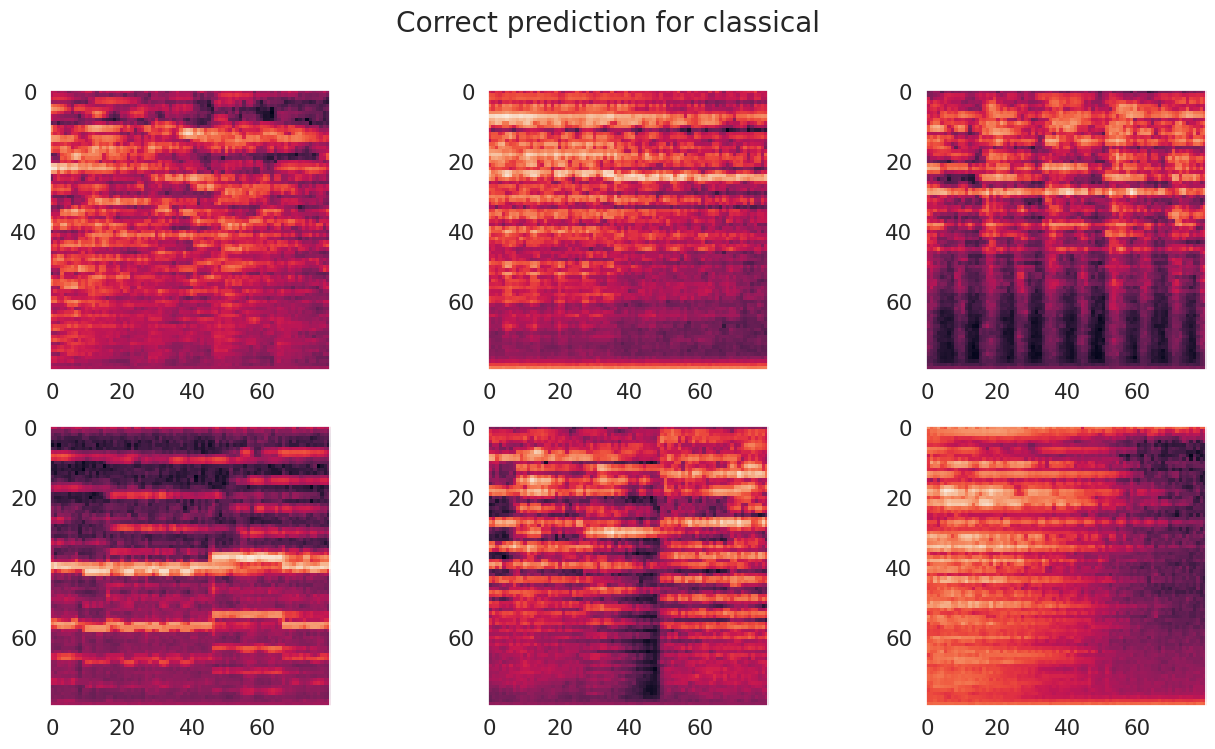

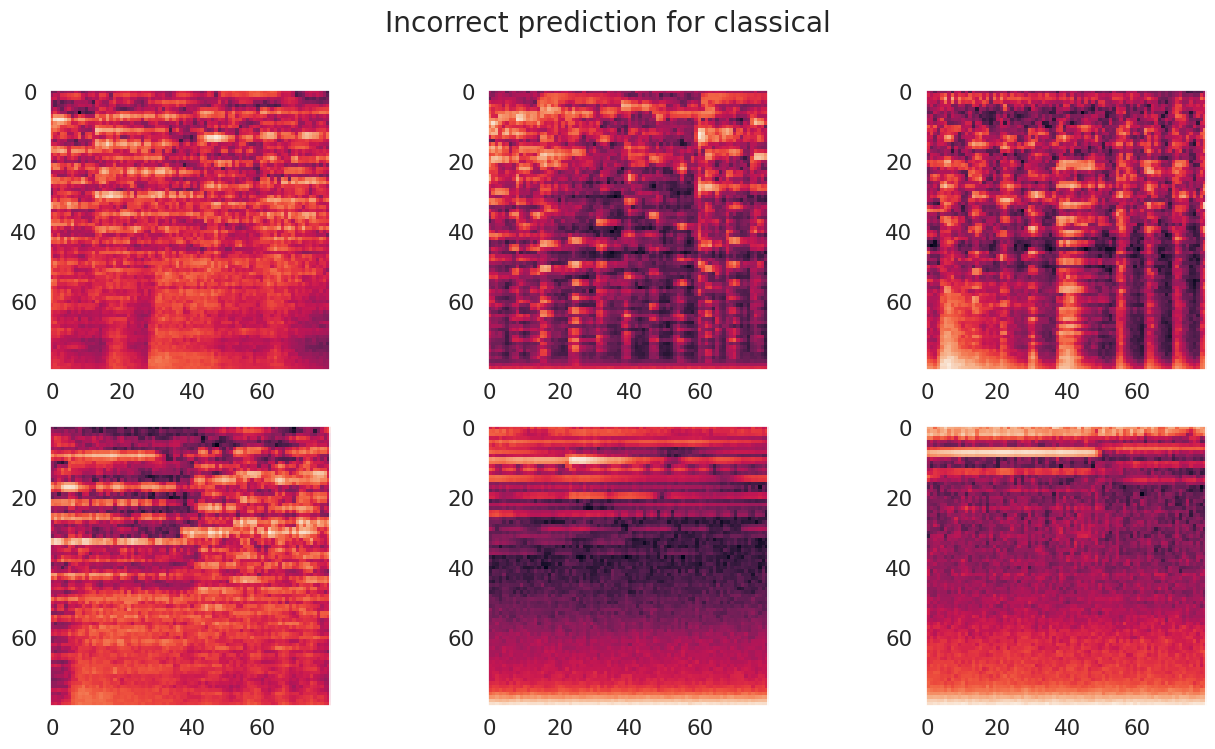

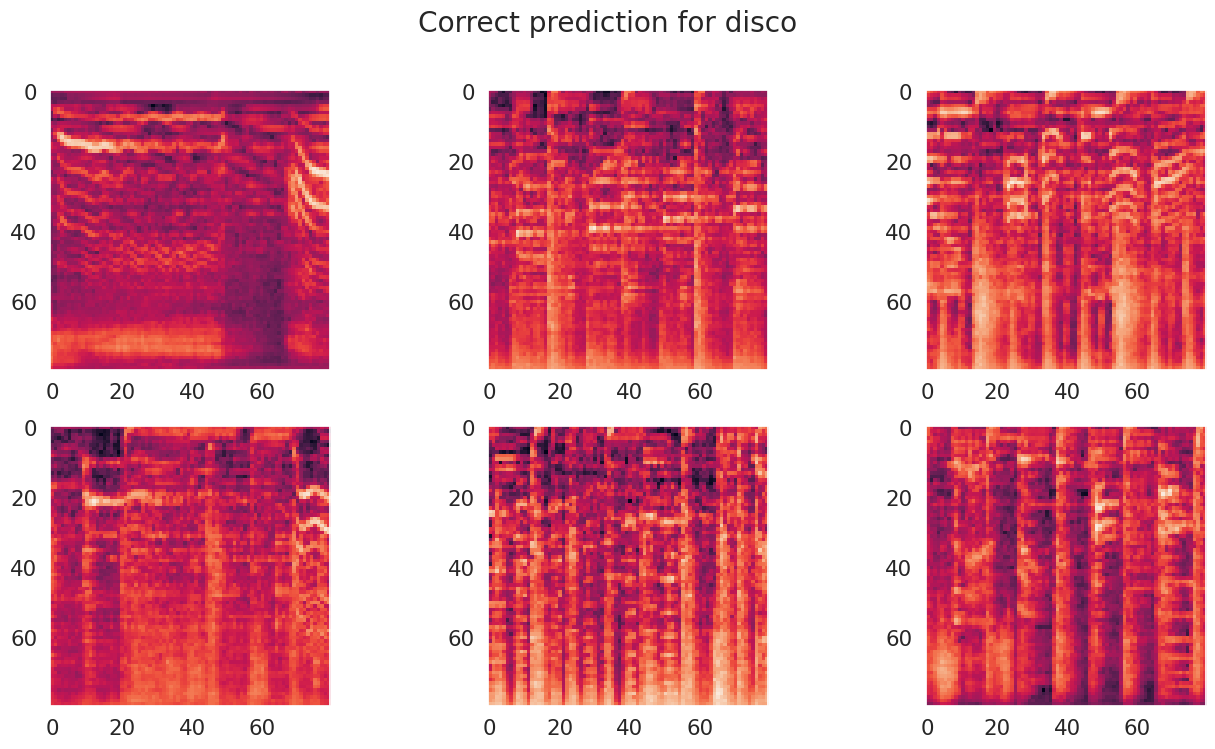

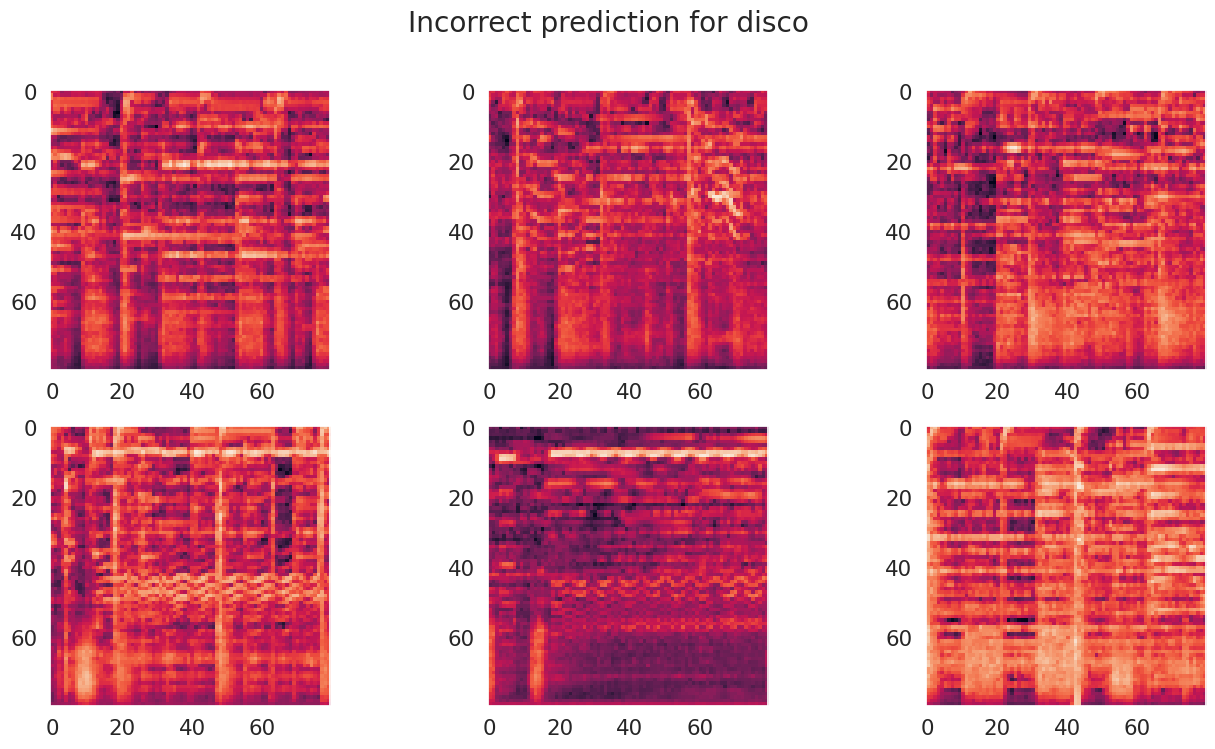

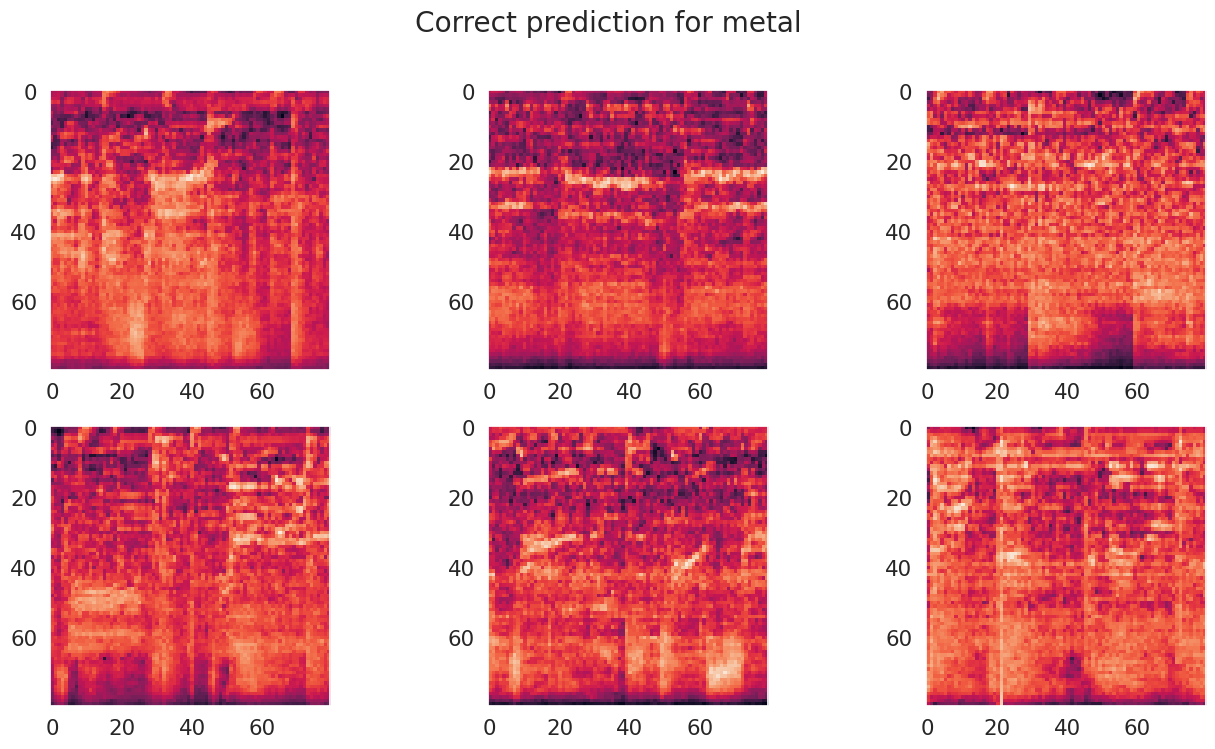

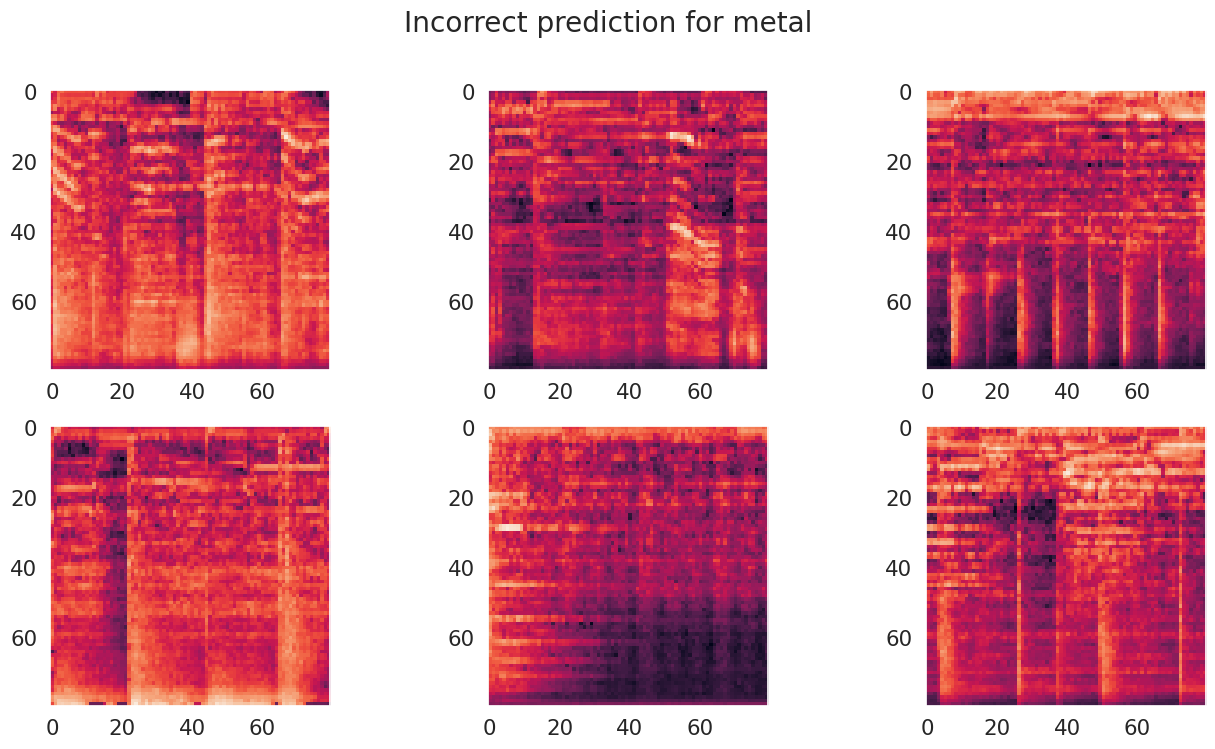

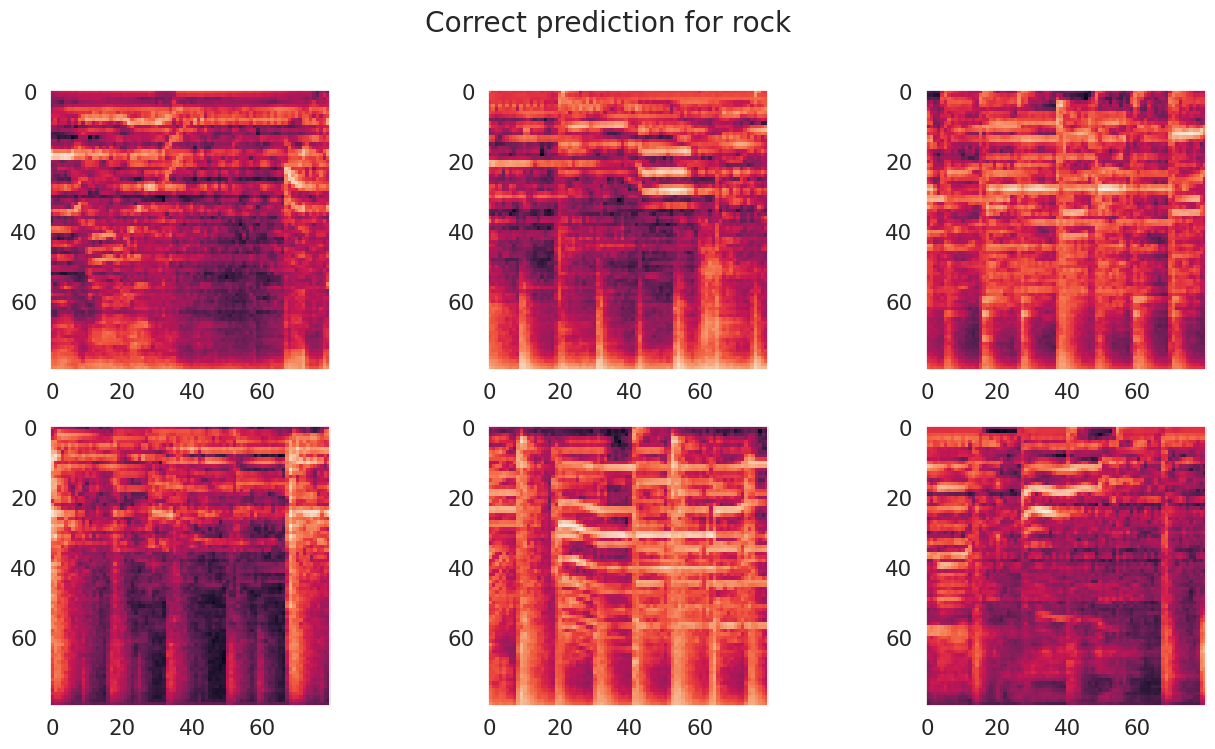

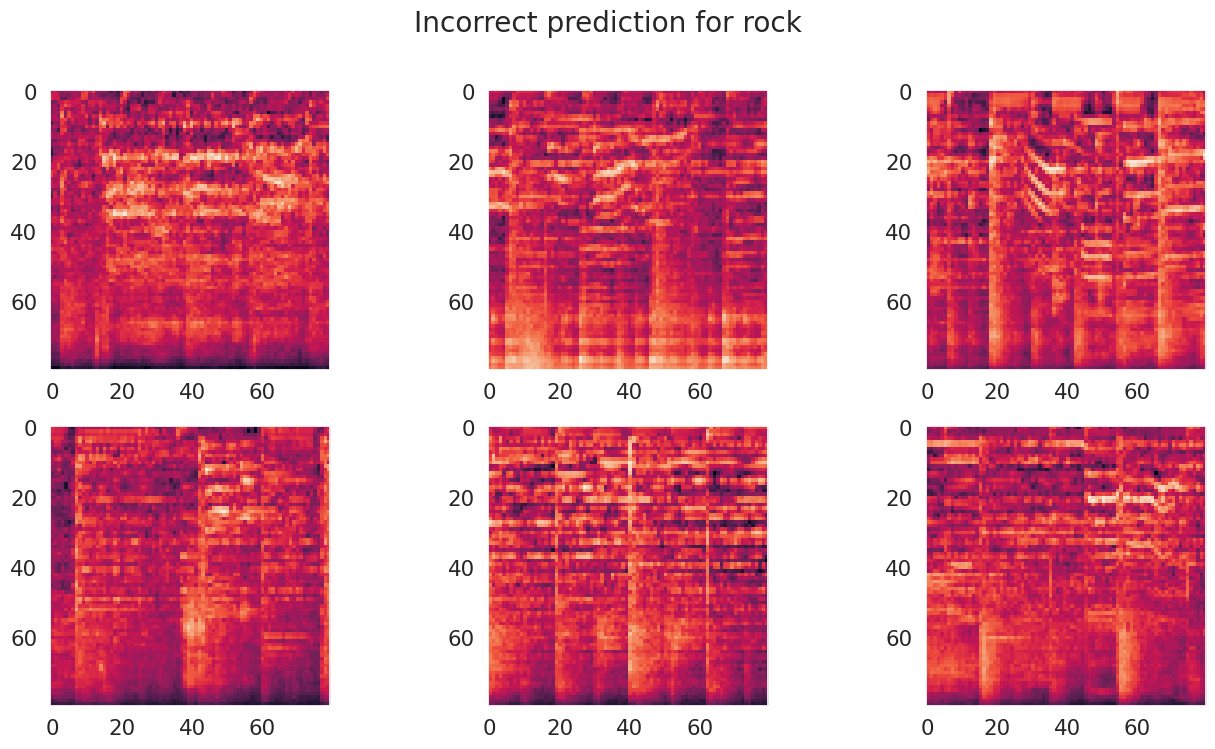

In [19]:
for i in range(4):
  cor, incor = ind_correct_uncorrect(model1, x_train, i)
  plot_spectrograms(2, 3, x_train, cor[:6])
  plt.suptitle(f'Correct prediction for {classes[i]}')
  plot_spectrograms(2, 3, x_train, incor[:6])
  plt.suptitle(f'Incorrect prediction for {classes[i]}')

**5.1. Using the function plot_spectrograms plot the 12 mel spectrograms of the first 6 data points which were predicted correctly and the first 6 which were predicted wrongly. Do you observe some differences among music genres?**

Ans: The correct spectrograms of classical music shows uniform patterns, while the rock and metal owns intense and varied textures. The correct spectrograms of disco shows patterns with regular rhythm. On the other hand, incorrect spectrograms often present with less characteristic of their categories, which were shown in the correct spectrograms.

In [20]:
for i in range (4):
  cor, incor=ind_correct_uncorrect(model1, x_train, i)
  print_wrong_prediction(model1, x_train, y_train, incor[:6], i, classes)

Wrongly predicted points for true class classical
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class disco
predicted class is metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class rock
predicted class is metal
predicted class is disco
predicted class is disco
predicted class is metal
predicted class is metal
predicted class is metal


**5.2. Using the function print_wrong_prediction print the predicted classes of the first 6 data points which were predicted wrongly.**

Ans: The result is shown as above.

In [21]:
model1.build(input_shape=input_shape)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

Text(0.5, 0.98, 'Grad-CAM of incorrect prediction')

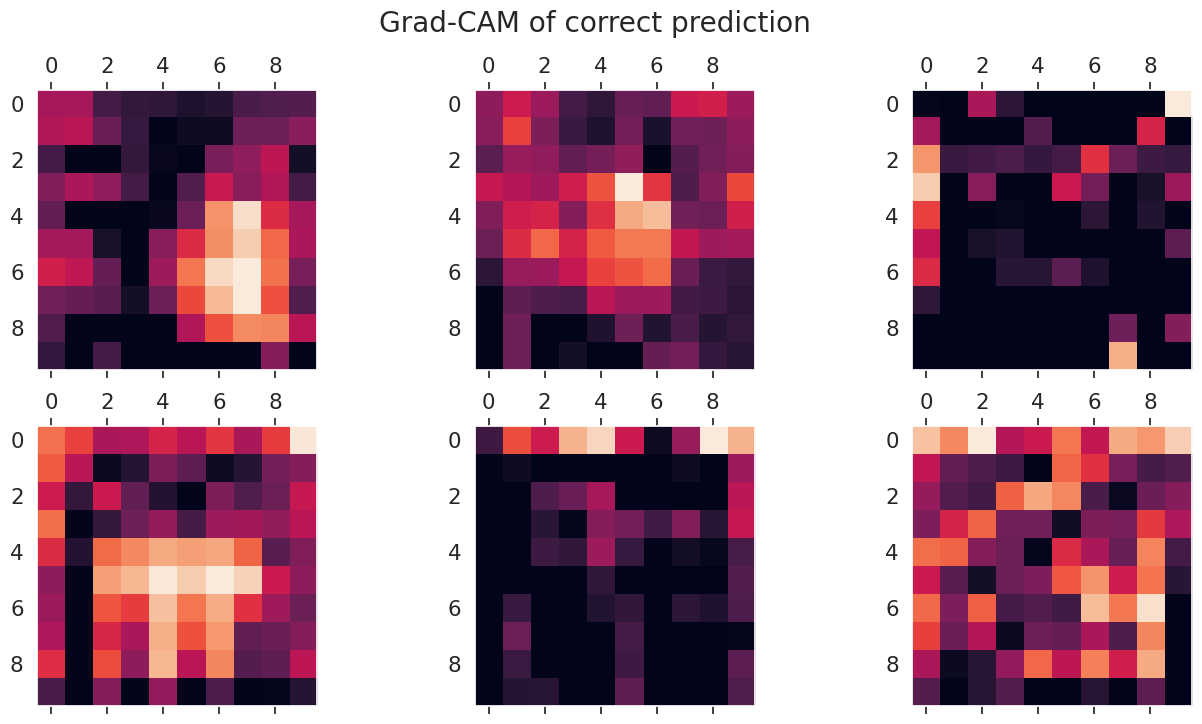

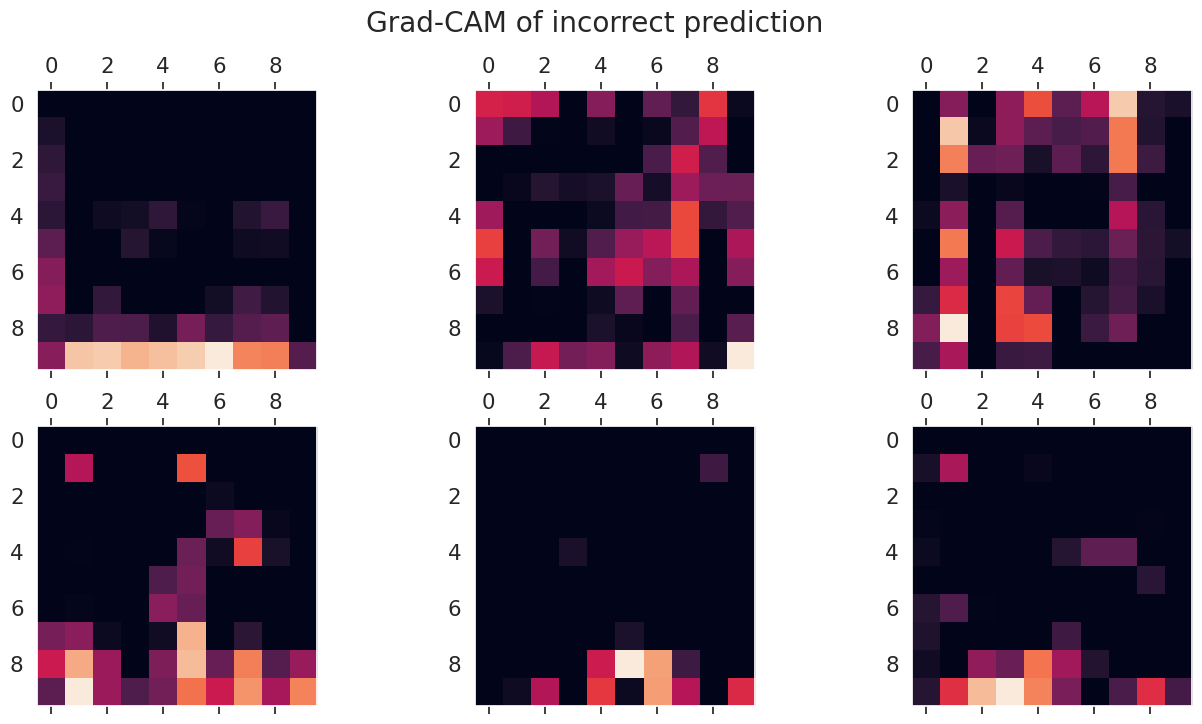

In [22]:
i_max=2
j_max=3
num_plots = i_max * j_max
plot_gradcam_spectrogram(i_max, j_max, x_train, cor[:num_plots],model1, 'max_pooling2d_2')
plt.suptitle('Grad-CAM of correct prediction')
plot_gradcam_spectrogram(i_max, j_max, x_train, incor[:num_plots],model1, 'max_pooling2d_2')
plt.suptitle('Grad-CAM of incorrect prediction')

**5.3. Using the Grad-CAM method, implemented in the function plot_gradcam_spectrogram, print the heatmaps of the last pooling layer for the same 12 extracts (6 correct + 6 wrong). Comment on the heatmaps obtained. Do you observe differences among the heatmaps of different music genres? Can you understand why the model got some predictions wrong?.**

Ans: The result is shown as above.

The heatmaps did not specify music genres, howwever we can infer certain characteristics. The activations of classical might spread across a wide range of frequencies. The metal should show strong activations mid to low-frequency, and the time axis may show consistent activation patterns, whilt the disco is similar, with consistent activation patterns over time at lower frequency. The rock should show varied patterns and prominent in mid-frequency.

In addition, the model predictions might base on specific  patterns within the time-frequency representation of musics. Therefore, in incorrect predictions,
heatmaps are more dispersed and less consistent, indicating that the model focused on those are not well-represented by the learned features.


**Q6. Comment on the previous question: what are your thoughts about the applicability of the Grad-CAM tool on these data?**
Grad-CAM provides insight into which parts of CNN focuses on to make the prediction. Though it is less straightforward while appliing to audio data, it can still offer valuable insights.

There are some advantages:

(1) Visualization of Time-Frequency

The Grad-CAM highlights specific rhythmic patterns,  harmonic structures of the characteristic of each genre.

(2) Model Debugging

Comparing the spectrogram of correct and incorrect predictions, we can identify potential biases or shortcomings in the training data or each layer of the model. This can help us find the bug and adjust the model for better performance.

(3) Interpretability of Model Predictions

Grad-CAM provides a way to reveal and gain some understanding of the   decision-making process of moedels, which is crucial for further model improvement.

However, there are still some limitations. First of all, the heatmaps can only dsecribe a single layer each time. In a mult-layer CNN model, we might need to plot heatmaps of every layer to find the crucial part or the bug existing in which layer. Last but not least, it is not straightforward that regions in heatmaps aren't exactly the area the images highlighted. Instead, a region corresponds to a specific time and frequency range.


# P2

**Explanation**

In this model, I separate the input by the 2 axis, time and frequency, as the requirement. As for layers, I set them in same structures and parameters as the P1, in order to compare the result of the 2-axis separation and the direct CNN. The one the difference is that the size of each filter become (5, 1) and (5,1) for the x-axis and y-axis pathway respectively because each pathway focus on its own axis, while the filter size of P1 is (5,5). Another difference is that the optimizer I used in this model is Adam instead of SGD in P1. The advantage of Adam is that it dynamically computes individual learning rates based on the past gradients, while SGD owns a single constant learning rate. The 2 pathways are finally merged into a final compiled model. Besides, I remain the regularizers l2, meaning that a dropout is not necessary.

The epoch I set is 30, and the final accuracy is 88.23%. Meanwhile, the test accuracy of P1 is 85.49%. What's more, the accuracy of 20st epoch in this model is 94.09 (92.04 in P1), and the accuracy of 30st epoch is 96.29%, which is much greater than testing accuracy 88.23%. The epoch number of 30 seems to be enough because the few epoches are aproaching 100% in a gradual tendency. In addition, though the testing accuracy is improved about 3% from P1, the overfitting problem is noticeable is this model. Last but not least, the confusion matrix reveals that the bia of some classical, disco and metal are misclassified as the rock music still remains.

In [15]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

input_shape=(80, 80, 1)
num_classes = 4

# Two separated inputs: for time and frequency
time_input = Input(shape=input_shape, name='time_input')
frequency_input = Input(shape=input_shape, name='frequency_input')

# Time pathway
time_conv1 = Conv2D(4, (5, 1), padding='same', activation='relu')(time_input)
time_pool1 = MaxPooling2D((2, 1))(time_conv1)
time_conv2 = Conv2D(8, (5, 1), padding='same', activation='relu')(time_pool1)
time_pool2 = MaxPooling2D((2, 1))(time_conv2)
time_conv3 = Conv2D(16, (5, 1), padding='same', activation='relu')(time_pool2)
time_pool3 = MaxPooling2D((2, 1))(time_conv3)
time_flat = Flatten()(time_pool3)

# Frequency pathway
frequency_conv1 = Conv2D(4, (1, 5), padding='same', activation='relu')(frequency_input)
frequency_pool1 = MaxPooling2D((1, 2))(frequency_conv1)
frequency_conv2 = Conv2D(8, (1, 5), padding='same', activation='relu')(frequency_pool1)
frequency_pool2 = MaxPooling2D((1, 2))(frequency_conv2)
frequency_conv3 = Conv2D(16, (1, 5), padding='same', activation='relu')(frequency_pool2)
frequency_pool3 = MaxPooling2D((1, 2))(frequency_conv3)
frequency_flat = Flatten()(frequency_pool3)

# Concatenate both pathways
merged = concatenate([time_flat, frequency_flat])

dense1 = Dense(100, activation='relu', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01))(merged)
output = Dense(num_classes, activation='softmax')(dense1)

model2 = Model(inputs=[time_input, frequency_input], outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

history3 = model2.fit([x_train, x_train], y_train, epochs=30, batch_size=32, validation_data=([x_val,x_val], y_val))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_input (InputLayer)     [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 frequency_input (InputLaye  [(None, 80, 80, 1)]          0         []                            
 r)                                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 4)            24        ['time_input[0][0]']          
                                                                                                  
 conv2d_3 (Conv2D)           (None, 80, 80, 4)            24        ['frequency_input[0][0]'] 

Text(0.5, 0.98, 'Loss and accuracy')

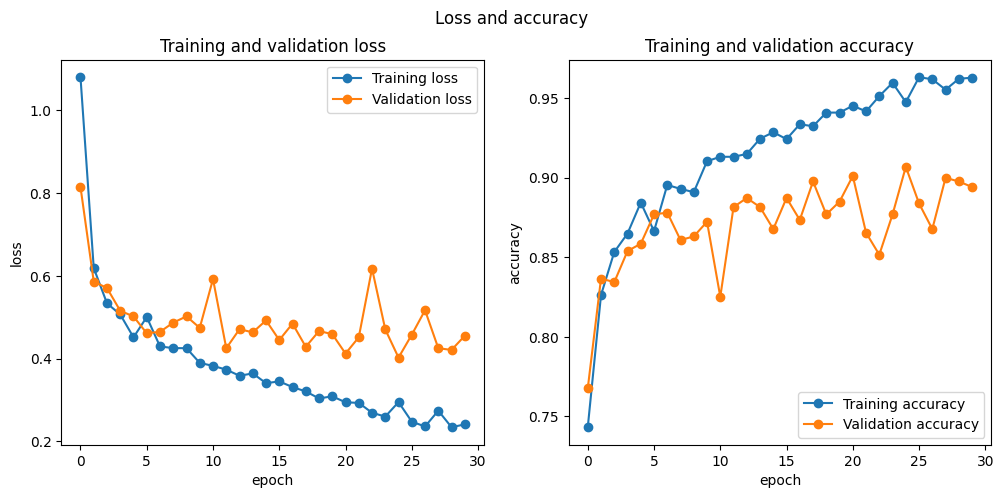

In [16]:
# training and validation loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history3.history['loss'],'-o', label='Training loss')
ax1.plot(history3.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history3.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history3.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('Loss and accuracy')

In [17]:
score = model2.evaluate([x_test, x_test], y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 88.23%


37/37 [==============================] - 1s 3ms/step


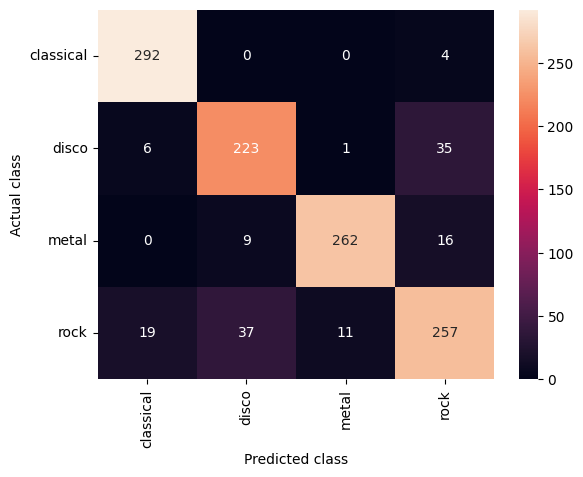

In [18]:
predictions = model2.predict([x_test,x_test])
# Convert predictions from one-hot encoded to numerical labels if necessary
y_pred_num = np.argmax(predictions, axis=1)
plot_confusion_matrix(y_test_num, y_pred_num, classes)